# Livrable 1 - Classification binaire



## 1. Chargement des données et constitution du jeu de données

### 1.1 Dépendances

Tout d'abord, nous ajoutons un ensemble de dépendances communes et spécifiques pour notre projet.

In [3]:
# Common dependancies
import os
import PIL
import tensorflow as tf
import pathlib
import time
import itertools
from datetime import datetime
from packaging import version
import sklearn
import io

# Specific dependancies
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Tensorboard
import tensorboard

# Keras tuner
import keras_tuner as kt

# TensorFlow
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorboard.plugins.hparams import api as hp

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### 1.2 Paramètres

Pour commencer, nous devons spécifier quelques paramètres pour l'apprentissage:
<ul>
    <li>La taille des images. </li>
    <li>La taille du batch.</li>
    <li>Le chemin du dossier source contenant les datasets</li>
    <p>Nous commençons par télécharger les images que nous allons utiliser pour faire de la classification d'images. Pour cela, il est nessaire d'ajouter un dossier contenant les différentes catégories d'images au niveau du répertoire racine du projet sous le nom <em>data<em>.

</ul>

In [28]:
IMAGE_SIZE = 180
BATCH_SIZE = 32
DATA_DIR = str(pathlib.Path().resolve() / "test")
AUTOTUNE = tf.data.experimental.AUTOTUNE
EPOCHS = 8

### 1.3 Chargement des datasets

Ensuite, nous devons partager le jeu de données en jeu d'entrainement (80% du jeu de données total) et en jeu de test (les 20% restants du jeu de données total).

In [31]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIR,
  validation_split= 0.2,
  subset = "training",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

# Le test_set
test_set = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 5004 files belonging to 5 classes.
Using 4004 files for training.
Found 5004 files belonging to 5 classes.
Using 1000 files for validation.


Le sortie précise qu'on a 41405 fichiers au complet dont 33124 appartenant au jeu d'entrainement et 8281 au jeu de test. Maintenant le jeu de données est prêt. Nous allons ensuite visualiser ces données.

## 2. Exploration et visualisation des données

Commençons, tout d'abord par afficher le nom des classes. Elles doivent correspondre aux différents types d'images (Photo, Peinture, Texte, ...)

In [32]:
CLASS_NAMES = train_set.class_names
NUM_CLASSES = 5 # Nombre de classes et donc aussi nombre de neurones dans la dernière couche
print(CLASS_NAMES)

['painting', 'photo', 'schematics', 'sketch', 'text']


Ici, on affiche quelques photos ainsi-que leurs labels pour vérifier l'import des données.

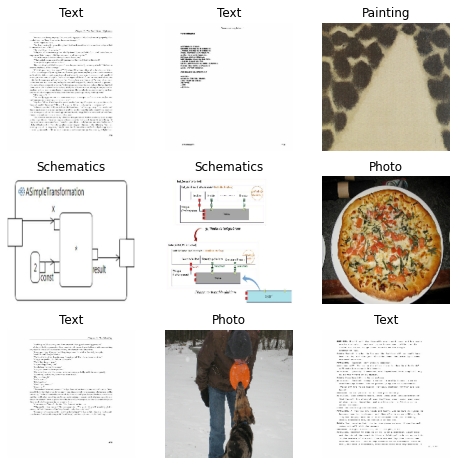

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax =  plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

Indication sur la taille des images :

In [6]:
print(type(train_set))
images, labels =  next(iter(train_set))
print(images.shape)
print(labels.shape)

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
(32, 180, 180, 3)
(32,)


Nous allons configurer les datasets pour améliorer les performances d'exécution

In [33]:
train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

## 3. Modèles et résultats

### 3.0 Exécutions préalables

#### 3.0.1 Fonctions utiles

Ici, nous préchargons différentes fonctions utiles pour la suite du livrable.

Les fonctions ci-dessous nous permettent de gérer la création et l'affichage d'une matrice au sein de Tensoboard.

In [59]:
def plot_confusion_matrix(cm, class_names):
  """
  Retourne une figure matplotlib contenant la matrice de confusion tracée.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Compute the labels from the normalized confusion matrix.
  labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

def plot_to_image(figure):
  """Convertit le tracé de matplotlib spécifié par 'figure' en une image PNG et
  la renvoie. La figure fournie est fermée et inaccessible après cet appel."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

# def log_confusion_matrix(epoch, logs, run_name, model):
#   logdir = "logs/image/" + run_name
#   file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

def log_confusion_matrix(epoch, logs):
  """Enregistre au sein de logs Tensorboard les images des matrices de confusion à chaque étape du modèle"""

  # Use the model to predict the values from the validation dataset.
  global model
  test_pred_raw = model.predict(test_images)
  test_pred = np.argmax(test_pred_raw, axis=1)

  # Calculate the confusion matrix.
  cm = metrics.confusion_matrix(test_labels, test_pred)
  # Log the confusion matrix as an image summary.
  figure = plot_confusion_matrix(cm, class_names=CLASS_NAMES)
  cm_image = plot_to_image(figure)

  # Log the confusion matrix as an image summary.
  with file_writer_cm.as_default():
    tf.summary.image("Confusion Matrix", cm_image, step=epoch)

Les 2 fonctions ci-dessous nous permettent de récupérer les prédictions réalisées par un modèle à partir des probabilités que celui-ci aura calculé.

In [9]:
# Turn probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """

  return unique_labels[np.argmax(prediction_probabilities)]


def get_pred_labels(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  labels=[]

  for item in prediction_probabilities:
    labels.append(np.argmax(item))
  #return unique_labels[np.argmax(prediction_probabilities)]
  return labels

La fonction ci-dessous nous permet de récupérer, à partir de tenseurs et de batchs, les données d'origine au format numpy.

In [10]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batch dataset of (image, label) Tensors and returns separate arrays of images and labels
  """
  images, labels = [], []

  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    #labels.append(unique_labels[label])
    labels.append(label)

  return images,labels

Les fonctions ci-dessous nous permettent d'illustrer les résultats de chaque modèle en affichant des illustrations et les probabilités calculées par le modèle.

In [11]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image.astype("uint8"))
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color="green"
  else:
    color="red"

  # Change plot title to be predicted, probability of prediction and truth
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-5:][::-1]
  # Find the top 10 prediction confidence value
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_labels[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

#### 3.0.2 Affichage des résultats Tensorboard

In [20]:
%tensorboard --logdir l1

Launching TensorBoard...

### 3.1 Modèle sans régularisation

#### 3.1.1 Modèle from scratch

Le modèle construit pour la classification d'images se base sur les réseaux de neurones convolutifs. Ce type de réseau, appelé CNN, est une architecture spécialisée de réseau de neurones qui a été créé afin d’apprendre efficacement les taches de vision par ordinateur.

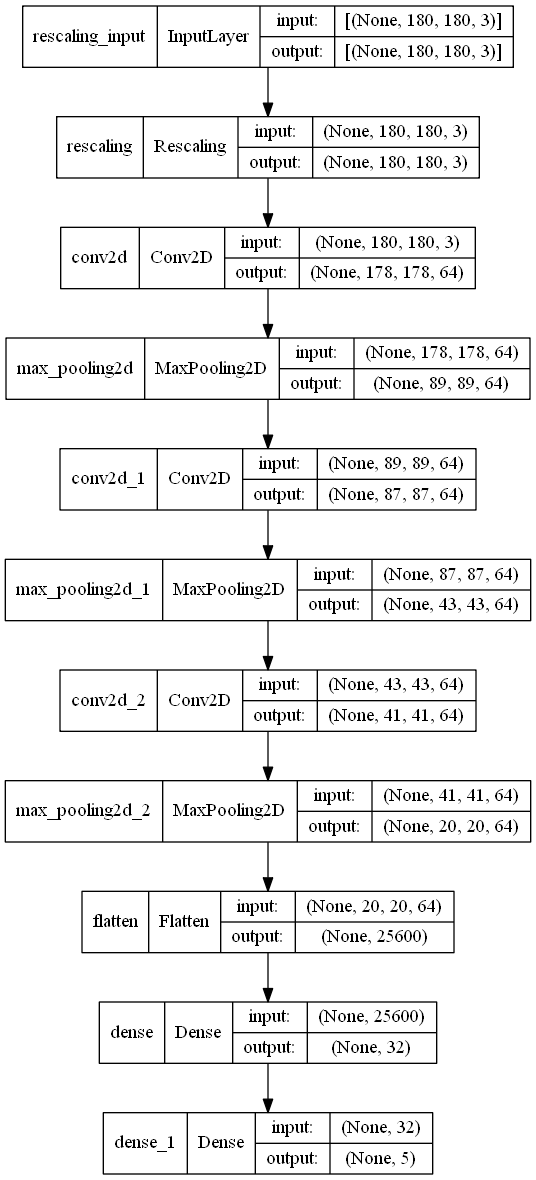

In [13]:
model = tf.keras.Sequential([
  # Normalisation
  tf.keras.layers.Rescaling(1./255),
    
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(NUM_CLASSES, activation = "softmax")
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

model.build((None, 180, 180, 3))
keras.utils.plot_model(model, show_shapes=True)

Ci-dessus, on peut voir un schéma du modèle sans régularisation. On a, dans l'ordre :

- Une couche de normalisation des données (rescaling) pour diviser l'entrée (la valeur d'une composante RVB d'un pixel) par 255 et transformer l'entrée dans l'intervalle [0, 1].
- 3 blocs convolutifs composés :
    - d'une couche convolutive avec 64 filtres de taille (3x3) avec un stride par défaut de 1: Elle sert à détecter la présence d'attributs au niveau de l'image en utilisant l'opération de convolution, et ainsi extraire de plus en plus de caractéristiques.
    - d'une couche de pooling : Elle sert à compresser la sortie de la couche convolutive en prenant l'information la plus saillante de celle-ci.
- Une couche contenant la couche précédente aplatie (flatten).
- Une couche entièrement connectée de taille 32.
- Une couche finale complètement connectée (dense) retournant le résultat de la classification.

Compilation du modèle et configuration de points de sauvegarde (pour éviter de relancer l'entrainement du modèle) :

In [14]:
# Model callback
checkpoint_path = "l1/without_regularization/save_at_{epoch}.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1)

# History callback
logdir="l1/without_regularization/"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Confusion matrix callback
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [15]:
callbacks=[
    checkpoint_callback,
    tensorboard_callback,
    # cm_callback,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
]

Lancement de l'entrainement du modèle :

In [16]:
history = model.fit(
  train_set,
  callbacks=callbacks,
  validation_data=test_set,
  epochs=EPOCHS
)

Epoch 1/8
1036/1036 [==============================] - ETA: 0s - loss: 0.5483 - accuracy: 0.7659
Epoch 00001: saving model to l1/without_regularization\save_at_1.h5
1036/1036 [==============================] - 814s 784ms/step - loss: 0.5483 - accuracy: 0.7659 - val_loss: 0.4276 - val_accuracy: 0.8135
Epoch 2/8
1036/1036 [==============================] - ETA: 0s - loss: 0.3511 - accuracy: 0.8571
Epoch 00002: saving model to l1/without_regularization\save_at_2.h5
1036/1036 [==============================] - 755s 729ms/step - loss: 0.3511 - accuracy: 0.8571 - val_loss: 0.3640 - val_accuracy: 0.8524
Epoch 3/8
1036/1036 [==============================] - ETA: 0s - loss: 0.2854 - accuracy: 0.8856
Epoch 00003: saving model to l1/without_regularization\save_at_3.h5
1036/1036 [==============================] - 743s 716ms/step - loss: 0.2854 - accuracy: 0.8856 - val_loss: 0.3074 - val_accuracy: 0.8780
Epoch 4/8
1036/1036 [==============================] - ETA: 0s - loss: 0.2343 - accuracy: 0.90

Ici, on peut voir que l'entraînement du modèle s'est arrêté prématurément car le callback d'earlystopping défini en amont a permis d'éviter une divergence trop importante de la perte entre le jeu de données et le jeu de validation.

#### 3.1.2 Récupération du modèle
<font color='red'>(Exécuter que si le fit n'a pas été exécuté)</font>

In [ ]:
# # Replace 'epoch' whit selected epoch or replace path with selected model
# model = keras.models.load_model("l1/without_regularization/save_at_{epoch}.h5")

#### 3.1.3 Affichage des résultats

Après avoir entraîné le modèle, nous réalisons une prédiction à partir du jeu de données de validation.

In [17]:
predictions = model.predict(test_set, verbose=1)  # verbose shows us how long there is to go
unique_labels = np.unique(CLASS_NAMES)

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_labels(predictions)

# Unbatchify the validation data
val_images, val_labels = unbatchify(test_set)

259/259 [==============================] - 38s 142ms/step


Nous affichons ici des images avec le label prédit, le pourcentage de la prédiction et le label prédit.

<function matplotlib.pyplot.show(close=None, block=None)>

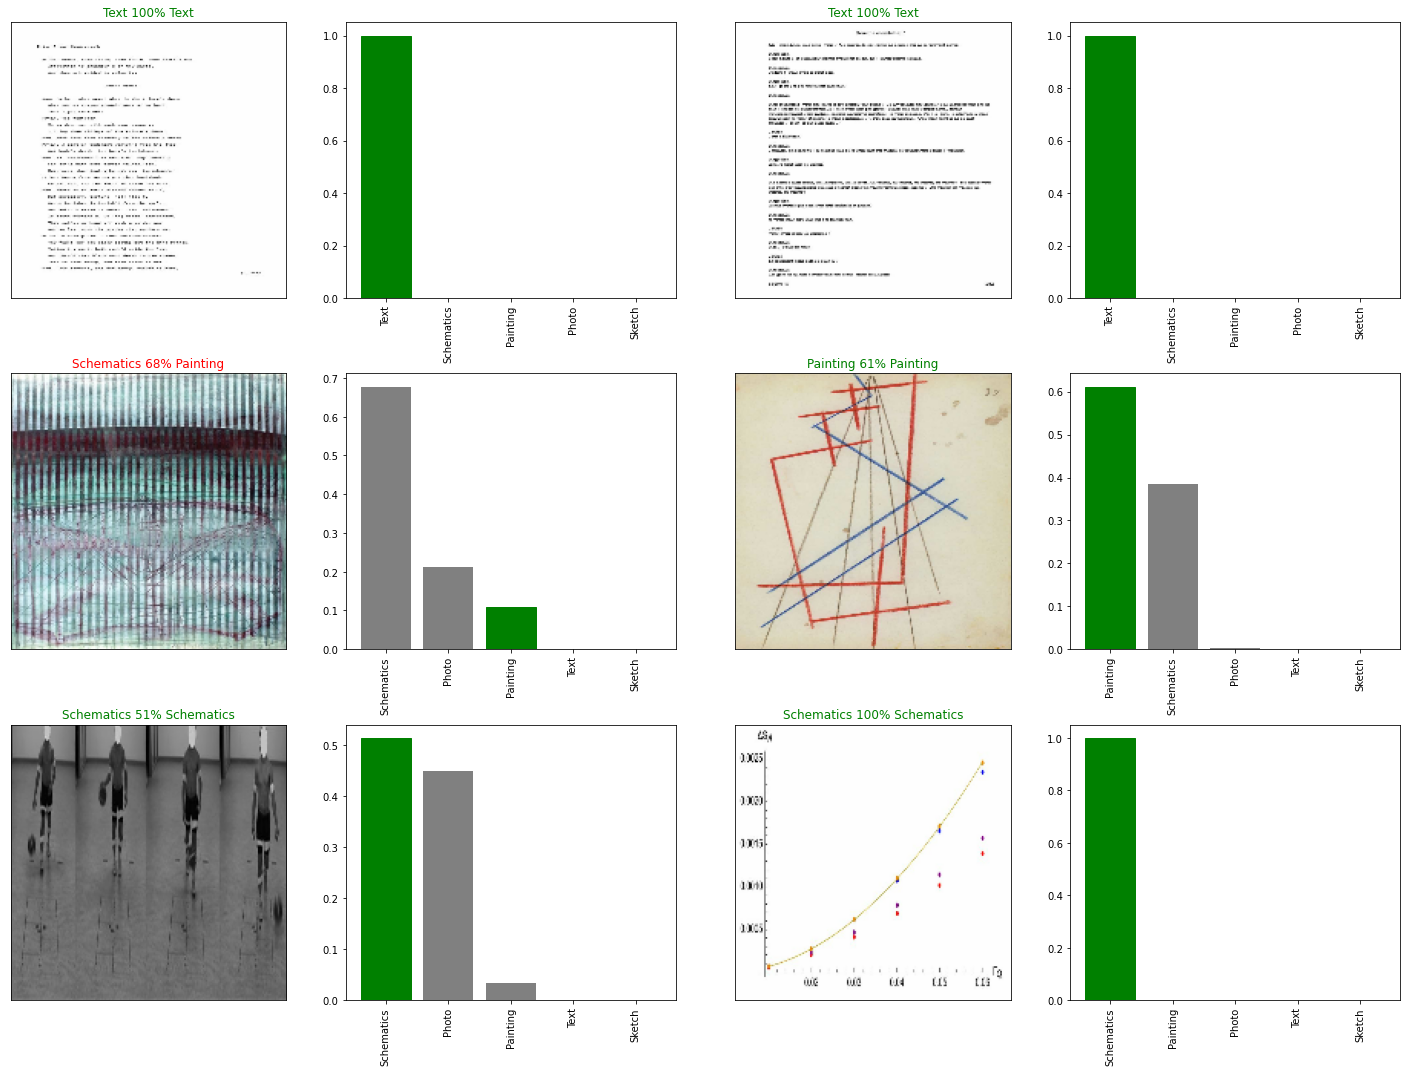

In [18]:
# Let's check out a few predictions and their different values
i_multiplier = 40
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=unique_labels[val_labels],
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=unique_labels[val_labels],
                 n=i+i_multiplier)
plt.tight_layout()
plt.show

On peut voir que malgré l'entrainement, des erreurs subsistent concernant les prédictions du modèle. Cela s'explique avec les courbes de précision et de perte de notre entrainement présentées ci-dessous :

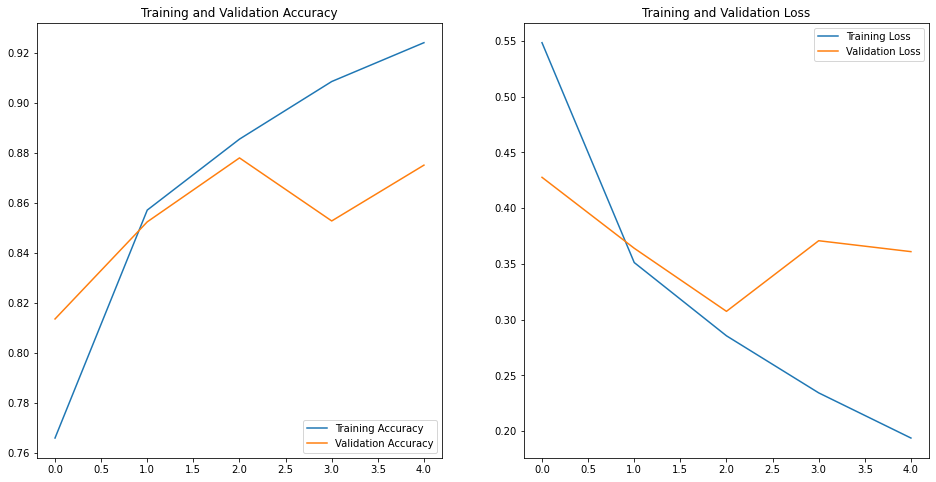

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

On peut voir ici plusieurs choses :
- La divergence décrite précédemment concernant l'arrêt prématuré de l'entraînement est visible ici. A partir de la 3ème époque, la précision de l'entrainement devient moins importante sur le jeu de validation, alors que la précision du jeu de données entraîné continue d'augmenter. Cela illustre un cas de sur apprentissage.
- La précision de notre modèle tourne aux alentours de 85%, ce qui explique pourquoi des erreurs restent présentes, comme nous avons pu voir précédemment.

Pour voir plus précisément l'efficacité de notre modèle, nous pouvons afficher une matrice de confusion. La matrice de confusion nous donne une connaissance détaillée des performances de notre classificateur sur les données de test.

Confusion Matrix :
[[1542  394   90    5    0]
 [ 277 1723   49    0    0]
 [  94   68 1768   12   12]
 [   0    0    4  283    0]
 [   0    0    5    0 1955]]
Accuracy Score is 0.8780340538582296
Classification Report : 
              precision    recall  f1-score   support

           0       0.81      0.76      0.78      2031
           1       0.79      0.84      0.81      2049
           2       0.92      0.90      0.91      1954
           3       0.94      0.99      0.96       287
           4       0.99      1.00      1.00      1960

    accuracy                           0.88      8281
   macro avg       0.89      0.90      0.89      8281
weighted avg       0.88      0.88      0.88      8281



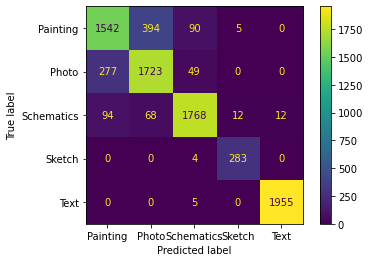

In [21]:
pred_label = get_pred_labels(predictions)

results = metrics.confusion_matrix(val_labels, pred_label)
print ('Confusion Matrix :')
print(results)
print ('Accuracy Score is',metrics.accuracy_score(val_labels, pred_label))
print ('Classification Report : ')
print (metrics.classification_report(val_labels, pred_label))

disp = metrics.ConfusionMatrixDisplay(confusion_matrix= results, display_labels= unique_labels)
disp.plot()
plt.show()

On peut conclure via la matrice de confusion que les peintures sont souvent confondues avec les photos. En effet, 277 photos ont été considérées comme des peintures et 394 peintures ont été considérées comme des photos. Malgré cela, on atteint une précision de 88%, ce qui est assez satisfaisant.

En plus de la précision, d'autres mesures sont également présentes pour évaluer la performance de notre modèle :

Le **score F1** qui peut être interprété comme une moyenne harmonique de la précision et du rappel :

$$ F1 =  \frac{2 * (precision * recall)}{(precision + recall)}  $$

Le **rappel** est le rapport où est le nombre de vrais positifs et le nombre de faux négatifs (capacité du classificateur à trouver tous les échantillons positifs) :

$$ recall =  \frac{(true positive)}{(true positive + false negative)}  $$

Ainsi, on peut voir que le modèle présente des difficulties à distinguer des caractéristiques entre les photos et les peintures. Nous allons chercher à améliorer notre modèle plus tard dans le livrable avec le tuning. Avant cela, nous allons adopter différentes méthodes pour réduire le surapprentissage.

## 3.2 Modèle avec régularisation

#### 3.2.1 Modèle from scratch

Avec cette seconde partie, nous cherchons à mettre en place des techniques de régularisation afin de réduire le surapprentissage. L’objectif est d’éviter que le réseau de neurones mémorise le jeu de données en s’ajustant bêtement sur les particularités du jeu d’entrainement. Il s’agit globalement de réduire les degrés de liberté du réseau de neurones. Différentes techniques existent pour cela :
- **L'earlystopping** : Vu précédemment dans le modèle, ce principe consiste à arrêter l'entrainement d'un modèle lorsque celui-ci diverge par rapport aux données de validation. Cela permet de stopper prématurément l'entrainement mais ne permet pas de minimiser/réduire le surapprentissage.
- **L’augmentation des données** : Avoir plus de données est toujours bon pour réduire le surapprentissage, d’où l’augmentation des données. Le principe et de rajouter de nouvelles images en effectuant des transformations sur le jeu d’entrainement d’origine. Ces nouvelles images sont obtenues par des transformations affines, ou généralement par des transformations réalistes qui ne change pas la nature du label affectée à l’image. Cette technique est très efficace car les réseaux de neurones sont très gourmands en données.
- **La technique de décrochage/dropout** : Cette technique consiste à désactiver, à chaque traitement, les neurones d’une couche dense du réseau de manière aléatoire. Le dropout dépend d’un paramètre qui représente la probabilité de désactivation des neurones de la couche. Cette probabilité est le la proportion moyenne de neurones actives dans la couche durant les itérations de l’entrainement. Elle permet de réduire la complexité du réseau de neurones pour réduire le surapprentissage.
- **La régularisation des poids** : étant donné certaines données d'entraînement et une architecture de réseau, il existe plusieurs ensembles de valeurs de poids (plusieurs modèles) qui pourraient expliquer les données, et les modèles plus simples sont moins susceptibles de surajuster que les modèles complexes. Grâce à cela, on évite les valeurs extrêmes car les poids conservent de petites valeurs, ce qui rend la distribution plus "régulière".

    - Régularisation L1 , où le coût supplémentaire est proportionnelle à la valeur absolue des coefficients de poids ( par exemple à ce qu'on appelle la « norme L1 » des poids).

    - Régularisation L2 , où le coût supplémentaire est proportionnelle au carré de la valeur des coefficients de poids ( par exemple à ce qu'on appelle le carré « L2 norme » des poids).

Pour notre modèle, nous allons mettre en application la régularisation des poids et la technique de décrochage :

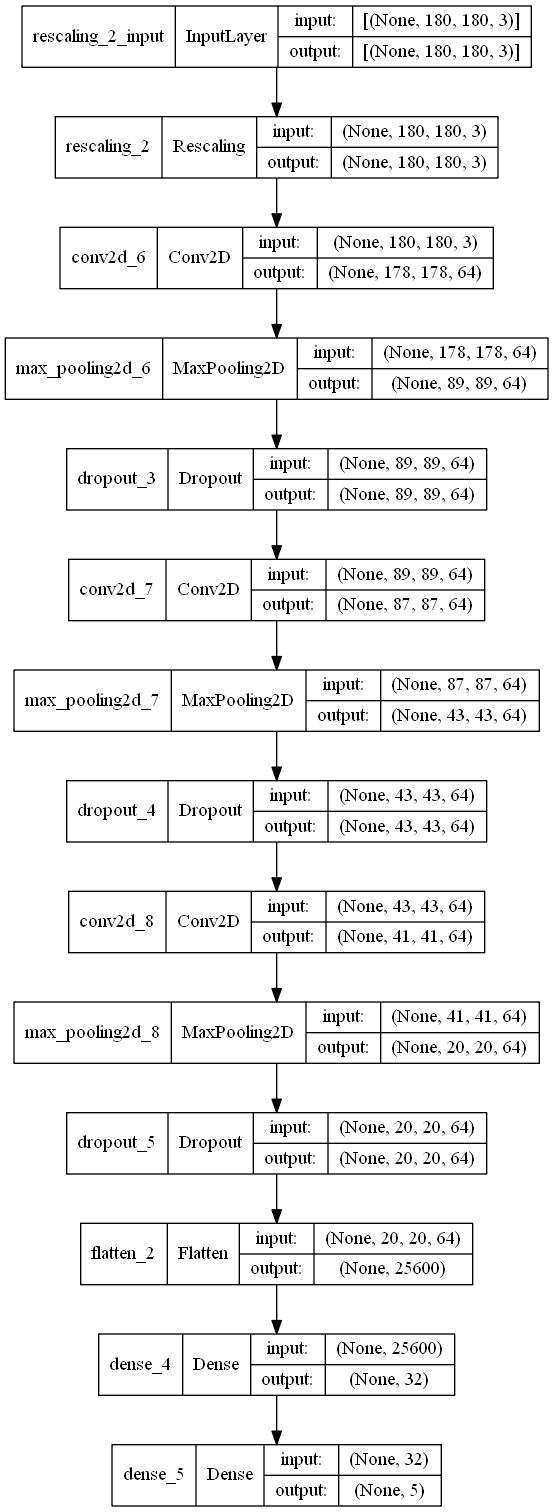

In [24]:
model = tf.keras.Sequential([
  # Normalisation
  tf.keras.layers.Rescaling(1./255),

  tf.keras.layers.Conv2D(64, 3, kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, 3, kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001), activation='relu'),
  tf.keras.layers.Dense(NUM_CLASSES, activation = "softmax")
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

model.build((None, 180, 180, 3))
keras.utils.plot_model(model, show_shapes=True)

Ci-dessus, on peut voir que le schéma du modèle change peu par rapport au précédent. On a comme différence notable l'ajout de couches de dropout pour désactiver une partie des poids concernés. La régularisation des poids se fait implicitement avec le passage en paramètre 'kernel_regularizer' au niveau des couches de convolution.

In [25]:
# Model callback
checkpoint_path = "l1/with_regularization/save_at_{epoch}.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,verbose=1,save_weights_only=True)

# History callback
logdir="l1/with_regularization/"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Confusion matrix callback
file_writer_cm = tf.summary.create_file_writer("l1/with_regularization/cm")
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [26]:
callbacks=[
    checkpoint_callback,
    tensorboard_callback,
    # cm_callback,
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
]

Lancement de l'entrainement du modèle :


In [27]:
history = model.fit(
  train_set,
  callbacks=callbacks,
  validation_data=test_set,
  epochs=EPOCHS
)

Epoch 1/8
1036/1036 [==============================] - ETA: 0s - loss: 0.6204 - accuracy: 0.7311
Epoch 00001: saving model to l1/with_regularization\save_at_1.h5
1036/1036 [==============================] - 907s 874ms/step - loss: 0.6204 - accuracy: 0.7311 - val_loss: 0.4973 - val_accuracy: 0.8061
Epoch 2/8
1036/1036 [==============================] - ETA: 0s - loss: 0.4380 - accuracy: 0.8258
Epoch 00002: saving model to l1/with_regularization\save_at_2.h5
1036/1036 [==============================] - 928s 895ms/step - loss: 0.4380 - accuracy: 0.8258 - val_loss: 0.4312 - val_accuracy: 0.8453
Epoch 3/8
1036/1036 [==============================] - ETA: 0s - loss: 0.3893 - accuracy: 0.8542
Epoch 00003: saving model to l1/with_regularization\save_at_3.h5
1036/1036 [==============================] - 906s 874ms/step - loss: 0.3893 - accuracy: 0.8542 - val_loss: 0.3871 - val_accuracy: 0.8555
Epoch 4/8
1036/1036 [==============================] - ETA: 0s - loss: 0.3542 - accuracy: 0.8717
Epoch 

#### 3.1.2 Récupération du modèle
<font color='red'>(Exécuter que si le fit n'a pas été exécuté)</font>

In [1]:
# # Replace 'epoch' whit selected epoch or replace path with selected model
# model = keras.models.load_model("l1/with_regularization/save_at_{epoch}.h5")

#### 3.2.3 Affichage des résultats

Après avoir entraîné le modèle, nous réalisons une prédiction à partir du jeu de données de validation.


In [28]:
predictions = model.predict(test_set, verbose=1)  # verbose shows us how long there is to go
unique_labels = np.unique(CLASS_NAMES)

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_labels(predictions)

# Unbatchify the validation data
val_images, val_labels = unbatchify(test_set)

259/259 [==============================] - 39s 150ms/step


Nous affichons ici des images avec le label prédit, le pourcentage de la prédiction et le label prédit.

<function matplotlib.pyplot.show(close=None, block=None)>

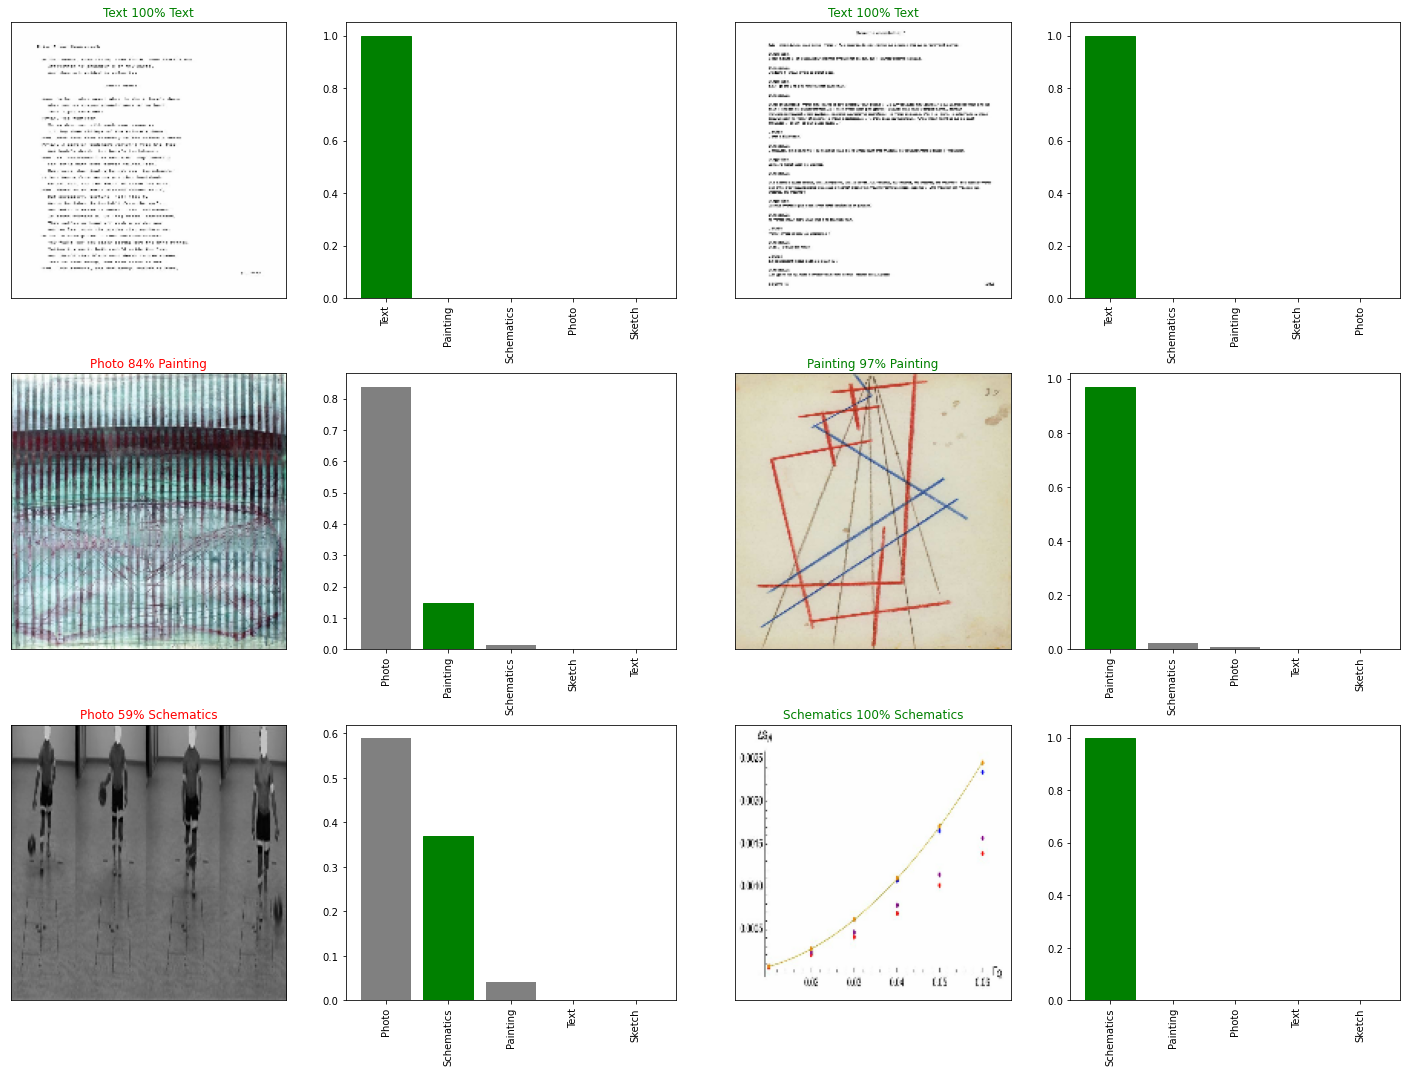

In [29]:
# Let's check out a few predictions and their different values
i_multiplier = 40
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=unique_labels[val_labels],
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=unique_labels[val_labels],
                 n=i+i_multiplier)
plt.tight_layout()
plt.show

On affiche ci-dessous la précision et la perte de notre jeu d'entrainement et de notre jeu de validation.

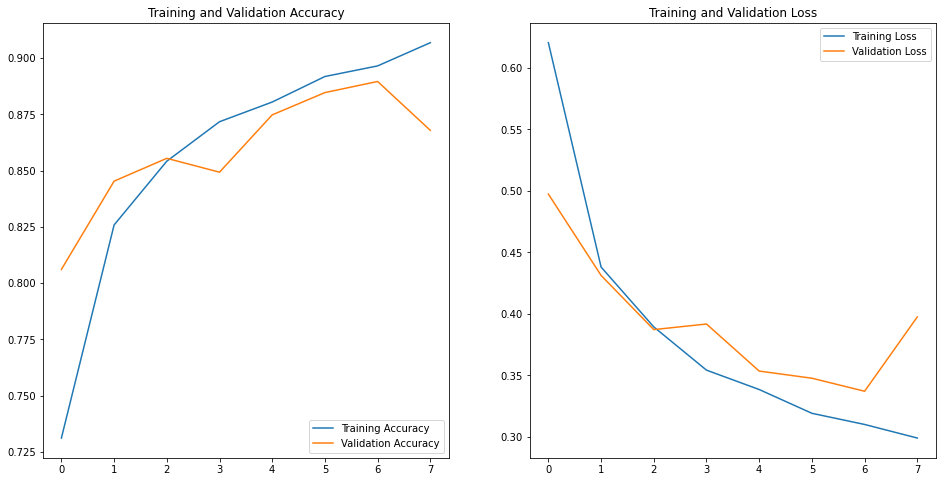

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(8)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Ainsi, avec l'ajout des paramètres de régularisation, on peut voir que le surapprentissage du modèle constaté à l'époque 3 et 4 est réduit. On peut ainsi poursuivre l'entrainement et obtenir un modèle plus précis.

Confusion Matrix :
[[1818  181   32    0    0]
 [ 513 1520   16    0    0]
 [ 231   73 1629    9   12]
 [  19    0    1  267    0]
 [   1    0    6    0 1953]]
Accuracy Score is 0.8678903514068349
Classification Report : 
              precision    recall  f1-score   support

           0       0.70      0.90      0.79      2031
           1       0.86      0.74      0.80      2049
           2       0.97      0.83      0.90      1954
           3       0.97      0.93      0.95       287
           4       0.99      1.00      1.00      1960

    accuracy                           0.87      8281
   macro avg       0.90      0.88      0.88      8281
weighted avg       0.88      0.87      0.87      8281



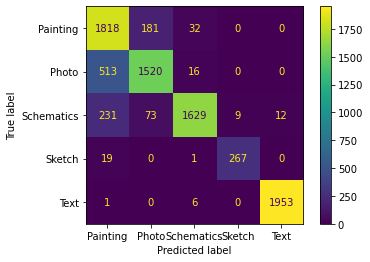

In [32]:
pred_label = get_pred_labels(predictions)

results = metrics.confusion_matrix(val_labels, pred_label)
print ('Confusion Matrix :')
print(results)
print ('Accuracy Score is',metrics.accuracy_score(val_labels, pred_label))
print ('Classification Report : ')
print (metrics.classification_report(val_labels, pred_label))

disp = metrics.ConfusionMatrixDisplay(confusion_matrix= results, display_labels= unique_labels)
disp.plot()
plt.show()

Ici, les peintures sont toujours confondues avec les photos. En effet, 513 photos ont été considérées comme des peintures et 181 peintures ont été considérées comme des photos. La précision reste au même niveau (87%), ce qui est assez satisfaisant.

Ainsi, on peut voir que le modèle présente toujours des difficulties à distinguer des caractéristiques entre les photos et les peintures. En effet, la régularisation n'a pas pour objectif d'améliorer notre modèle. Nous allons pour cela appliquer des méthodes de tuning.

### 3.3 Tuning (à corriger)

In [70]:
HP_CONV = hp.HParam('conv', hp.Discrete([16, 32, 64, 128]))
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32, 64, 128]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.2, 0.3, 0.4]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

with tf.summary.create_file_writer('l1/with_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_CONV, HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric('accuracy', display_name='Accuracy')],
  )

In [61]:
# Unbatchify the validation data
test_images, test_labels = unbatchify(test_set)

In [67]:
test_images = tf.convert_to_tensor(test_images)
test_labels = tf.convert_to_tensor(test_labels)

In [71]:
def tuning_model(hparams, run_name):
    input = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = layers.Rescaling(1./255)(input)
    x = layers.Conv2D(hparams[HP_CONV], 3, kernel_regularizer=regularizers.l2(0.0001), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(hparams[HP_DROPOUT])(x)
    x = layers.Conv2D(hparams[HP_CONV], 3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = layers.Conv2D(hparams[HP_CONV], 3, kernel_regularizer=regularizers.l2(0.0001), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(hparams[HP_DROPOUT])(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.0001))(x)
    output = tf.keras.layers.Dense(NUM_CLASSES, activation = "softmax")(x)

    global model
    model = keras.Model(input, output, name="tuning")

    model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'],
    )

    model.fit(
      train_set,
      callbacks=[
          keras.callbacks.TensorBoard(log_dir=logdir),
        keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix),
        keras.callbacks.ModelCheckpoint("l1/with_tuning/"+run_name+"/save_at_{epoch}.h5"),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
    ],
      validation_data=test_set,
      epochs=EPOCHS
    )
    return model

def run(run_name, hparams):
  with tf.summary.create_file_writer('l1/with_tuning/' + run_name).as_default():
    global file_writer_cm
    file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')
    hp.hparams(hparams)  # record the values used in this trial
    global model
    model = tuning_model(hparams, run_name)
    tf.summary.scalar('accuracy', model.evaluate(test_images, test_labels), step=1)

In [15]:
%tensorboard --logdir l1

Launching TensorBoard...

In [72]:
session_num = 0

for conv in HP_CONV.domain.values:
  for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in HP_DROPOUT.domain.values:
      for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
              HP_CONV: conv,
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        logdir = 'l1/with_tuning/' + run_name
        run(run_name, hparams)
        session_num += 1

--- Starting trial: run-0
{'conv': 16, 'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam'}
Epoch 1/8
126/126 [==============================] - 28s 216ms/step - loss: 1.2499 - accuracy: 0.4578 - val_loss: 0.9570 - val_accuracy: 0.6090
Epoch 2/8
126/126 [==============================] - 28s 222ms/step - loss: 0.7493 - accuracy: 0.7025 - val_loss: 0.6290 - val_accuracy: 0.7330
Epoch 3/8
126/126 [==============================] - 28s 225ms/step - loss: 0.5544 - accuracy: 0.7752 - val_loss: 0.4940 - val_accuracy: 0.7890
Epoch 4/8
126/126 [==============================] - 25s 202ms/step - loss: 0.4795 - accuracy: 0.8044 - val_loss: 0.4506 - val_accuracy: 0.8200
Epoch 5/8
126/126 [==============================] - 28s 221ms/step - loss: 0.4311 - accuracy: 0.8272 - val_loss: 0.4346 - val_accuracy: 0.8310
Epoch 6/8
126/126 [==============================] - 28s 225ms/step - loss: 0.3828 - accuracy: 0.8511 - val_loss: 0.4603 - val_accuracy: 0.8210
Epoch 7/8
32/32 [==========================

ValueError: Expected scalar shape, saw shape: (2,).

On observe que la courbe de performance augmente au cours des "epochs". La précision du jeu de test atteint une valeur relativement proche de celle du jeu d'entrainement. Et la perte du jeu d'entrainement et du jeu de test baisse continuellement.